# Medical MNIST denoising

Ref: https://towardsdatascience.com/autoencoders-in-practice-dimensionality-reduction-and-image-denoising-ed9b9201e7e1

In [21]:
from kaggle import api
from zipfile import ZipFile
import splitfolders
import os
import shutil

dataset = 'andrewmvd/medical-mnist'
zip_file = './medical-mnist.zip'
extract_folder = 'medical_mnist_archive'
split_folder = 'medical_mnist'

api.dataset_download_files(dataset)

with ZipFile(zip_file, 'r') as zip:
    zip.extractall(extract_folder)

splitfolders.ratio(input=extract_folder, output=split_folder, seed=101, ratio=(.8, .2), move=True)

os.remove(zip_file)
shutil.rmtree(extract_folder)

2023-10-04 12:12:42,004 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))': /api/v1/datasets/download/andrewmvd/medical-mnist?datasetVersionNumber=None
Copying files: 58954 files [00:20, 2904.59 files/s]


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Specifiy the path to training and validation folder
train_dir = f'{split_folder}/train'
test_dir = f'{split_folder}/val'

# Apply image generator
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(44, 44),
                                                   batch_size= 47163,
                                                   class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,target_size=(44, 44),
                                                   batch_size=11791,
                                                   class_mode='categorical')

# Fetch training and test data and their ground-trith label
x_train, y_train = next(train_generator)
x_test, y_test  = next(test_generator)

n_examples = 500
example_images = x_test[0:n_examples]
example_labels = y_test[0:n_examples]

labels = [np.where(i==1)[0][0] for i in example_labels]

Found 47163 images belonging to 6 classes.
Found 11791 images belonging to 6 classes.


In [25]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Reshape

encoded_dim = 2

encoder = Sequential([
    Conv2D(input_shape=(44,44,3), filters= 64, kernel_size = (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D( (2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(encoded_dim)
])

In [26]:
decoder = Sequential ([
    Dense(1936, activation = 'relu', input_shape=(encoded_dim,)),
    Reshape((11,11,16)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), padding='same') 
])

In [28]:
autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))

autoencoder_dr.compile(loss = 'mse')

autoencoder_dr.fit(x_train, x_train, epochs = 1, verbose=1)

1474/1474 [==============================] - 188s 127ms/step - loss: 0.0229


NameError: name 'pretrain_encodings' is not defined

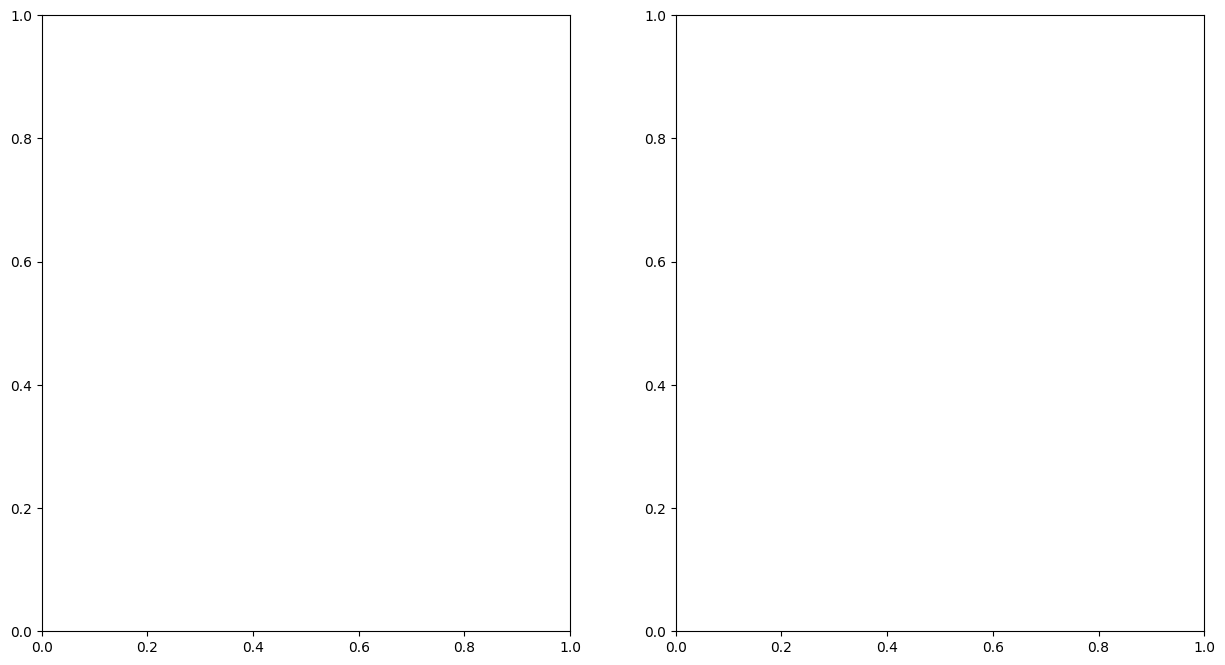

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

posttrain_encodings = encoder(example_images).numpy()

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
sns.scatterplot(pretrain_encodings[:, 0],
                pretrain_encodings[:, 1],
                hue=class_names[labels], ax=axs[0],
                palette=sns.color_palette("colorblind", 6));
sns.scatterplot(posttrain_encodings[:, 0],
                posttrain_encodings[:, 1],
                hue=class_names[labels], ax=axs[1],
                palette=sns.color_palette("colorblind", 6));

axs[0].set_title('Encodings of example images before training');
axs[1].set_title('Encodings of example images after training');

for ax in axs: 
    ax.set_xlabel('Encoding dimension 1')
    ax.set_ylabel('Encoding dimension 2')
    ax.legend(loc='upper right')